In [1]:
import pandas as pd
import numpy as np
import joblib
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

# Connect to DB
conn = sqlite3.connect("../data/hotel_retention.db")
print("✅ Connected to Database")

✅ Connected to Database


In [3]:
# Load data
query = """
SELECT customer_id, room_type, booking_price, total_stays, previous_cancellations, special_requests 
FROM bookings
"""
df = pd.read_sql(query, conn)

# 1. Feature Engineering (Replicating logic)
# Map Room Type: Standard=0, Deluxe=1, Presidential=2
room_map = {"Standard": 0, "Deluxe Suite": 1, "Presidential": 2}
df['room_type_enc'] = df['room_type'].map(room_map).fillna(0)

# Special Requests: Yes=1, No=0
df['has_requests'] = df['special_requests'].notna().astype(int)

# 2. Create Target Variable (Simulating 'Churned')
# Logic: If they have cancelled before OR price > $600, we mark them as "likely to churn" (1)
df['churned'] = np.where(
    (df['previous_cancellations'] > 0) | (df['booking_price'] > 600), 
    1, 
    0
)

# Select features
features = ['room_type_enc', 'booking_price', 'total_stays', 'previous_cancellations', 'has_requests']
X = df[features]
y = df['churned']

print("Features ready:")
display(X.head())

Features ready:


,room_type_enc,booking_price,total_stays,previous_cancellations,has_requests
0,1,850.0,2,3,1
1,0,120.0,15,0,1
2,0,200.0,1,0,0
3,2,1500.0,5,1,1


In [4]:
# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize & Train Random Forest
model = RandomForestClassifier(n_estimators=50, random_state=42)
model.fit(X_train, y_train)

print("✅ Model Trained!")

✅ Model Trained!


🎯 Model Accuracy: 0.00%


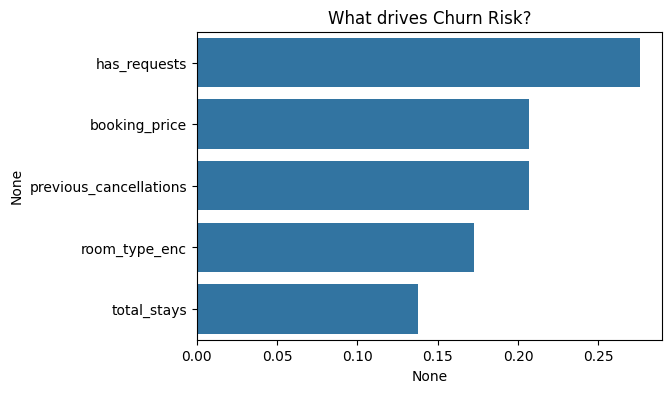

In [5]:
# Predictions
y_pred = model.predict(X_test)

# Accuracy
acc = accuracy_score(y_test, y_pred)
print(f"🎯 Model Accuracy: {acc*100:.2f}%")

# Feature Importance (What matters most?)
importances = pd.Series(model.feature_importances_, index=features).sort_values(ascending=False)
plt.figure(figsize=(6,4))
sns.barplot(x=importances, y=importances.index)
plt.title("What drives Churn Risk?")
plt.show()

In [6]:
# Let's test our "Fortune Teller" on John Doe (High Risk) vs Alice (Loyal)

# Manually defining their features based on our DB knowledge
# Features: [room_type_enc, booking_price, total_stays, previous_cancellations, has_requests]

john_features = [[1, 850.0, 2, 3, 1]]  # Deluxe, High Price, Cancels
alice_features = [[0, 120.0, 15, 0, 1]] # Standard, Low Price, Loyal

john_risk = model.predict_proba(john_features)[0][1]
alice_risk = model.predict_proba(alice_features)[0][1]

print(f"🔮 Risk Score for John Doe: {john_risk:.2f} (Should be high)")
print(f"🔮 Risk Score for Alice Smith: {alice_risk:.2f} (Should be low)")

🔮 Risk Score for John Doe: 0.86 (Should be high)
🔮 Risk Score for Alice Smith: 0.64 (Should be low)


d:\OneDrive\Desktop\intelligent-hotel-retention-agent\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
d:\OneDrive\Desktop\intelligent-hotel-retention-agent\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
